In [1]:
import mysql.connector as mysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mydb = mysql.connect(
    host="localhost",
    user="root",
    password="password",
    database="ecommerce",
    auth_plugin='caching_sha2_password'
)

mycursor = mydb.cursor()

List all unique cities where customers are located

In [ ]:
query="""SELECT DISTINCT
    (customer_city)
FROM
    customers"""
mycursor.execute(query)
data = mycursor.fetchall()
city = pd.DataFrame(data)
print(city)

                          0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]


Count the no. of orders placed in each year

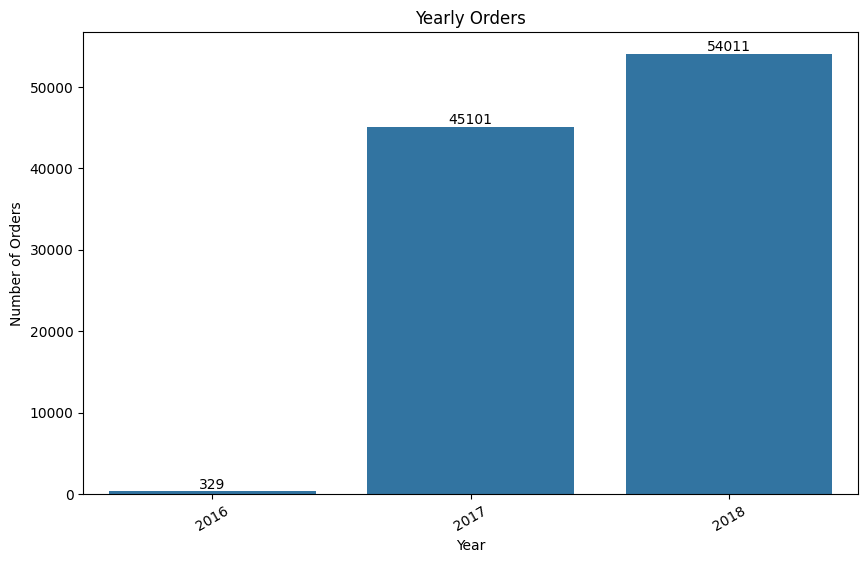

In [48]:
query="""SELECT 
	YEAR(order_purchase_timestamp), COUNT(order_id)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) IN ('2016','2017','2018')
GROUP BY YEAR(order_purchase_timestamp)"""
mycursor.execute(query)
data = mycursor.fetchall()
yearly_orders = pd.DataFrame(data, columns=['Year', 'Order_Count'])
orders = ["2016", "2017", "2018"]
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Year', y='Order_Count', data=yearly_orders, order=orders)
plt.bar_label(bars.containers[0])
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.title('Yearly Orders')
plt.xticks(rotation=30)
plt.show()

Find the total sales per category

In [ ]:
query = """SELECT 
    UPPER(product_category), ROUND(SUM(payment_value), 2)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY product_category"""
mycursor.execute(query)
data = mycursor.fetchall()
sales = pd.DataFrame(data, columns=['Category', 'Total_Sales'])
print(sales)

                       Category  Total_Sales
0                     PERFUMERY    506738.66
1          FURNITURE DECORATION   1430176.39
2                     TELEPHONY    486882.05
3                BED TABLE BATH   1712553.67
4                    AUTOMOTIVE    852294.33
..                          ...          ...
69               CDS MUSIC DVDS      1199.43
70                   LA CUISINE      2913.53
71  FASHION CHILDREN'S CLOTHING       785.67
72                     PC GAMER      2174.43
73       INSURANCE AND SERVICES       324.51

[74 rows x 2 columns]


Calculate the percentage of orders that were paid in installments

In [ ]:
query="""SELECT 
    (SUM((CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*)) * 100
FROM
    payments"""
mycursor.execute(query)
data = mycursor.fetchall()
print("Percentage of orders with installments:", data[0][0])

Percentage of orders with installments: 99.9981


Count the no. of customers from each state

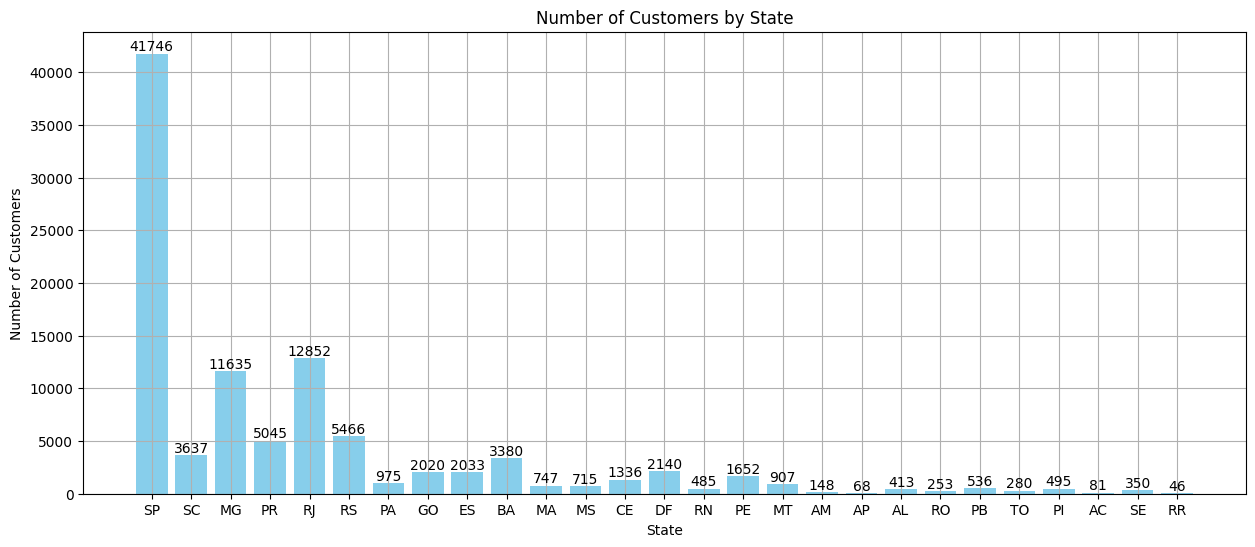

In [5]:
query="""SELECT 
    customer_state, COUNT(*)
FROM
    customers
GROUP BY customer_state"""
mycursor.execute(query)
data = mycursor.fetchall()
state_counts = pd.DataFrame(data, columns=['State', 'Count'])
plt.figure(figsize=(15, 6))
bars=plt.bar(state_counts['State'], state_counts['Count'], color='skyblue')
plt.bar_label(bars)
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by State')
plt.grid()
plt.show()

Count the no. of orders from each product category

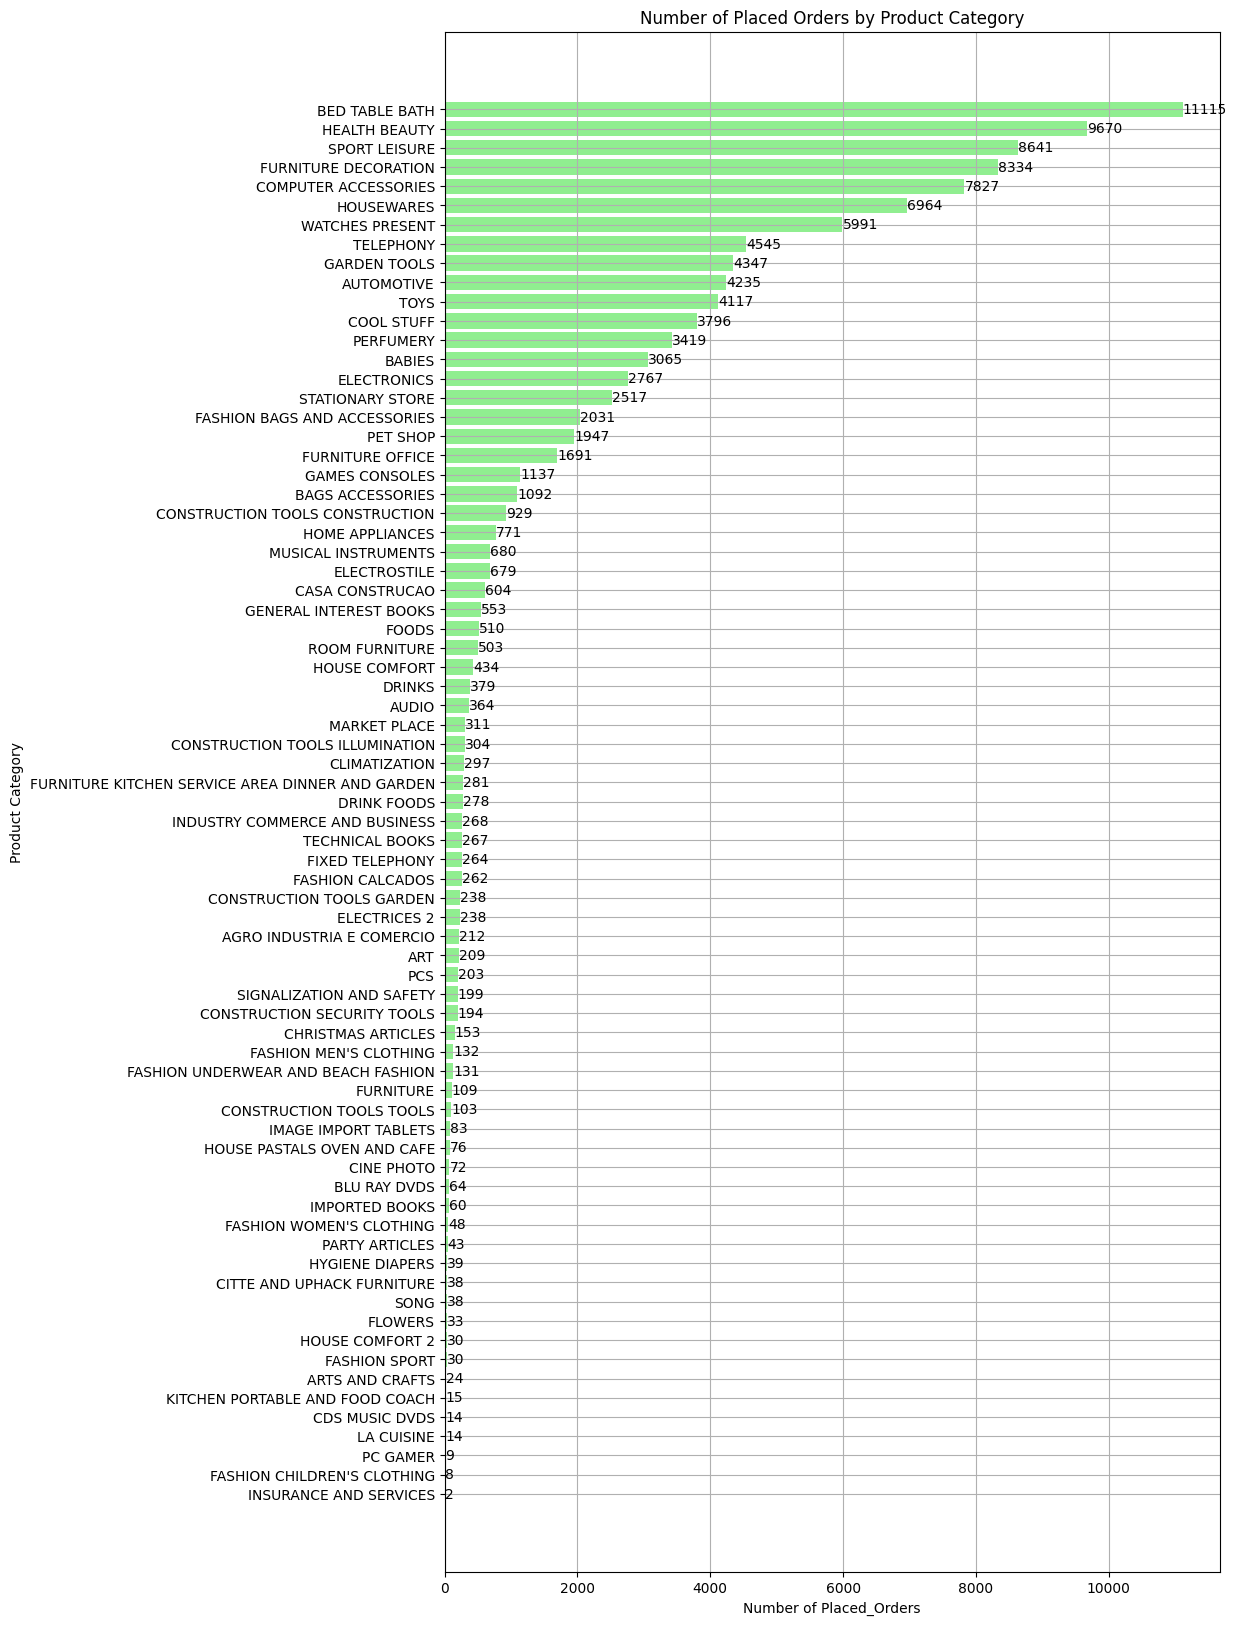

In [ ]:
query="""SELECT 
    UPPER(product_category), COUNT(*)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY product_category
ORDER BY COUNT(*) ASC"""
mycursor.execute(query)
data = mycursor.fetchall()
product_counts = pd.DataFrame(data, columns=['Category', 'Count'])
product_counts = product_counts[product_counts['Category'].notna()]
plt.figure(figsize=(10, 20))
bars=plt.barh(product_counts['Category'], product_counts['Count'], color='lightgreen')
plt.bar_label(bars)
plt.xlabel('Number of Orders')
plt.ylabel('Product Category')
plt.title('Number of Orders by Product Category')
plt.grid()
plt.show()

Calculate the no. of orders per month in 2018

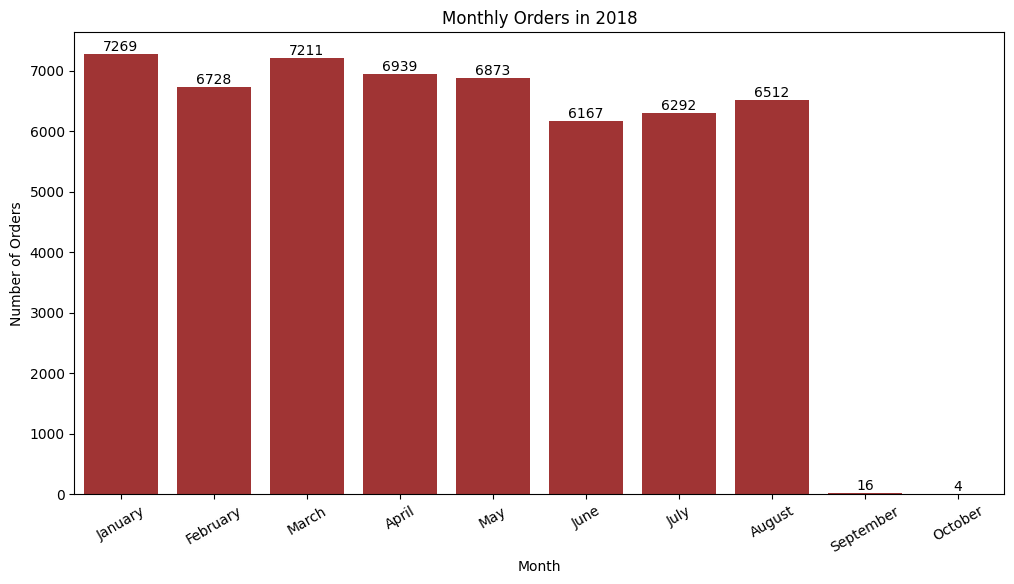

In [56]:
query="""SELECT 
    MONTHNAME(order_purchase_timestamp), COUNT(*)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTHNAME(order_purchase_timestamp)"""
mycursor.execute(query)
data = mycursor.fetchall()
monthly_orders = pd.DataFrame(data, columns=['Month', 'Order_Count'])
plt.figure(figsize=(12, 6))
orders= ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
bars=sns.barplot(x='Month', y='Order_Count', data=monthly_orders, order=orders, color='firebrick')
plt.bar_label(bars.containers[0])
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Monthly Orders in 2018')
plt.xticks(rotation=30)
plt.show()

Find the average no. of products per order grouped by customer city

In [ ]:
query="""WITH count_order AS (SELECT 
    orders.order_id, customer_id, COUNT(order_items.order_id) AS county
FROM
    orders
        JOIN
    order_items ON orders.order_id = order_items.order_id
GROUP BY orders.order_id , customer_id)

SELECT 
    customer_city, ROUND(AVG(county),2)
FROM
    customers
        JOIN
    count_order ON customers.customer_id = count_order.customer_id
GROUP BY customer_city
ORDER BY AVG(county) DESC"""
mycursor.execute(query)
data = mycursor.fetchall()
avg_products_per_order = pd.DataFrame(data, columns=['City', 'Avg_Products_Per_Order'])
print(avg_products_per_order)

                      City Avg_Products_Per_Order
0           padre carvalho                   7.00
1              celso ramos                   6.50
2                    datas                   6.00
3            candido godoi                   6.00
4           matias olimpio                   5.00
...                    ...                    ...
4105        lagoa da canoa                   1.00
4106            japaratuba                   1.00
4107        sebastiao leal                   1.00
4108  morro agudo de goias                   1.00
4109         padre paraiso                   1.00

[4110 rows x 2 columns]


Calculate the percentage of total revenue contributed by each product category

In [31]:
query="""SELECT 
    product_category,
    ROUND(((SUM(payment_value)) / (SELECT 
                    SUM(payment_value)
                FROM
                    payments)) * 100,
            2) AS sales
FROM
    payments
        JOIN
    order_items ON payments.order_id = order_items.order_id
        JOIN
    products ON products.product_id = order_items.product_id
GROUP BY product_category
ORDER BY sales DESC"""
mycursor.execute(query)
data = mycursor.fetchall()
category_sales = pd.DataFrame(data, columns=['Category', 'Sales_Percentage_Distribution'])
print(category_sales)

                       Category  Sales_Percentage_Distribution
0                bed table bath                          10.70
1                 HEALTH BEAUTY                          10.35
2          computer accessories                           9.90
3          Furniture Decoration                           8.93
4               Watches present                           8.93
..                          ...                            ...
69              House Comfort 2                           0.01
70               cds music dvds                           0.01
71                     PC Gamer                           0.01
72  Fashion Children's Clothing                           0.00
73       insurance and services                           0.00

[74 rows x 2 columns]


Identify the correlation between product price and the number of times a product has been purchased

In [14]:
query="""SELECT 
    product_category, COUNT(order_id), AVG(price)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY product_category"""
mycursor.execute(query)
data = mycursor.fetchall()
product_category_stats = pd.DataFrame(data, columns=['Product_Category', 'Order_Count', 'Average_Price'])
a=product_category_stats['Order_Count']
b=product_category_stats['Average_Price']
c=np.corrcoef(a,b)
print("Correlation between Order Count and Average Price:", c[0][1])

Correlation between Order Count and Average Price: -0.10631552237549534


Calculate the total revenue generated by each seller, and rank them by revenue

In [18]:
query="""SELECT
    seller_id, SUM(payment_value), DENSE_RANK() OVER (ORDER BY SUM(payment_value) DESC)
FROM
    payments
        JOIN
    order_items ON payments.order_id=order_items.order_id
GROUP BY seller_id"""
mycursor.execute(query)
data = mycursor.fetchall()
seller_performance = pd.DataFrame(data, columns=['Seller_ID', 'Total_Sales', 'Rank'])
print(seller_performance)

                             Seller_ID    Total_Sales  Rank
0     7c67e1448b00f6e969d365cea6b010ab  507166.907302     1
1     1025f0e2d44d7041d6cf58b6550e0bfa  308222.039840     2
2     4a3ca9315b744ce9f8e9374361493884  301245.269765     3
3     1f50f920176fa81dab994f9023523100  290253.420128     4
4     53243585a1d6dc2643021fd1853d8905  284903.080498     5
...                                ...            ...   ...
3090  ad14615bdd492b01b0d97922e87cb87f      19.209999  3082
3091  702835e4b785b67a084280efca355756      18.559999  3083
3092  4965a7002cca77301c82d3f91b82e1a9      16.360001  3084
3093  77128dec4bec4878c37ab7d6169d6f26      15.220000  3085
3094  cf6f6bc4df3999b9c6440f124fb2f687      12.220000  3086

[3095 rows x 3 columns]


Calculate the moving average of order values for each customer over their order history

In [ ]:
query="""WITH payment_per_order AS (SELECT
    customer_id, order_purchase_timestamp, payment_value
FROM
    payments
        JOIN
    orders ON payments.order_id=orders.order_id)

SELECT customer_id, order_purchase_timestamp, payment_value, AVG(payment_value)
OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW)
FROM payment_per_order"""
mycursor.execute(query)
data = mycursor.fetchall()
moving_avg_payment = pd.DataFrame(data, columns=['Customer_ID', 'Order_Timestamp', 'Payment', 'Avg_Payment_Last_3'])
print(moving_avg_payment)

                             Customer_ID      Order_Timestamp  Payment  \
0       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74   
1       000161a058600d5901f007fab4c27140  2017-07-16 09:40:32    67.41   
2       0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43   195.42   
3       0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20   179.35   
4       000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17   107.01   
...                                  ...                  ...      ...   
103881  fffecc9f79fd8c764f843e9951b11341  2018-03-29 16:59:26    71.23   
103882  fffeda5b6d849fbd39689bb92087f431  2018-05-22 13:36:02    63.13   
103883  ffff42319e9b2d713724ae527742af25  2018-06-13 16:57:05   214.13   
103884  ffffa3172527f765de70084a7e53aae8  2017-09-02 11:53:32    45.50   
103885  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03    18.37   

        Avg_Payment_Last_3  
0               114.739998  
1                67.410004  
2               195.4199

Calculate the cumulative sales per month for each year

In [ ]:
query="""WITH payment_per_order AS (select
    YEAR(order_purchase_timestamp) AS years, MONTH(order_purchase_timestamp) AS months, ROUND(SUM(payment_value),2) AS payment
FROM
    payments
        JOIN
    orders ON payments.order_id=orders.order_id
GROUP BY years, months
ORDER BY years, months)

SELECT years, months, payment, SUM(payment) OVER (ORDER BY years, months)
FROM payment_per_order"""
mycursor.execute(query)
data = mycursor.fetchall()
cumulative_sales = pd.DataFrame(data, columns=['Year', 'Month', 'Payment', 'Cumulative_sales'])
print(cumulative_sales)

    Year  Month     Payment  Cumulative_sales
0   2016      9      252.24            252.24
1   2016     10    59090.48          59342.72
2   2016     12       19.62          59362.34
3   2017      1   138488.04         197850.38
4   2017      2   291908.01         489758.39
5   2017      3   449863.60         939621.99
6   2017      4   417788.03        1357410.02
7   2017      5   592918.82        1950328.84
8   2017      6   511276.38        2461605.22
9   2017      7   592382.92        3053988.14
10  2017      8   674396.32        3728384.46
11  2017      9   727762.45        4456146.91
12  2017     10   779677.88        5235824.79
13  2017     11  1194882.80        6430707.59
14  2017     12   878401.48        7309109.07
15  2018      1  1115004.18        8424113.25
16  2018      2   992463.34        9416576.59
17  2018      3  1159652.12       10576228.71
18  2018      4  1160785.48       11737014.19
19  2018      5  1153982.15       12890996.34
20  2018      6  1023880.50       

Calculate the year-over-year growth rate of total sales

   Year     Payment  Previous_Year_Payment  Growth_Rate
0  2016    59362.34                    NaN          NaN
1  2017  7249746.73               59362.34      12112.7
2  2018  8699763.05             7249746.73         20.0


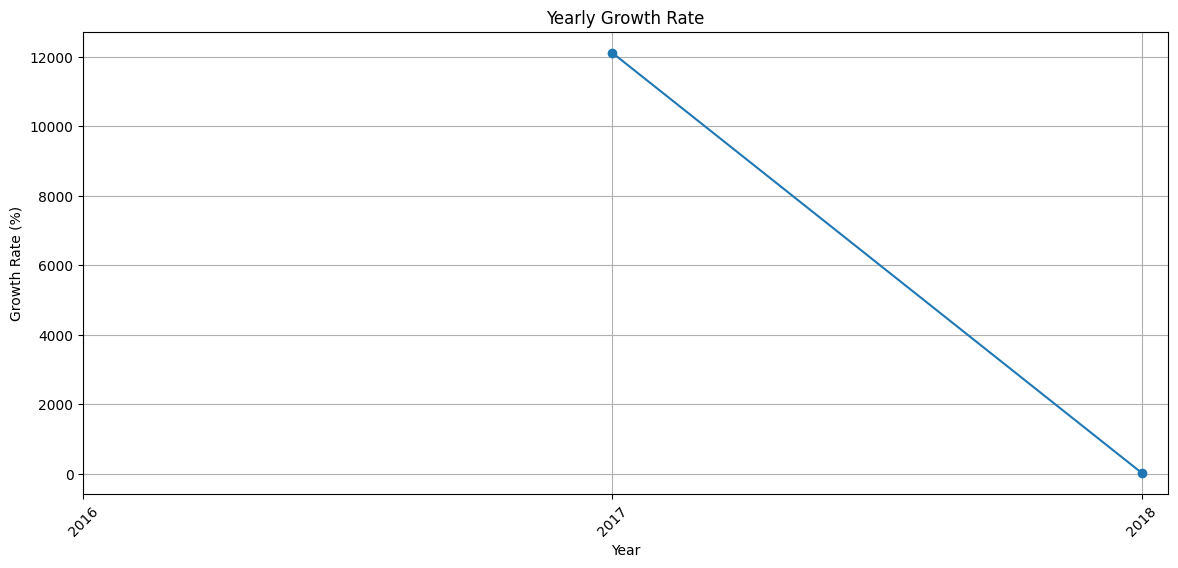

In [34]:
query="""WITH payment_per_order AS (SELECT
    YEAR(order_purchase_timestamp) AS years, ROUND(SUM(payment_value),2) AS payment
FROM
    payments
        JOIN
    orders ON payments.order_id=orders.order_id
GROUP BY years
ORDER BY years)

SELECT years, payment, LAG(payment, 1) OVER (ORDER BY years), ROUND(((payment - LAG(payment, 1) OVER (ORDER BY years))/LAG(payment, 1) OVER (ORDER BY years))*100,2)
FROM payment_per_order"""
mycursor.execute(query)
data = mycursor.fetchall()
yearly_growth = pd.DataFrame(data, columns=['Year', 'Payment', 'Previous_Year_Payment', 'Growth_Rate'])
print(yearly_growth)
plt.figure(figsize=(14, 6))
plt.plot(yearly_growth['Year'], yearly_growth['Growth_Rate'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks(yearly_growth['Year'], rotation=45)
plt.title('Yearly Growth Rate')
plt.grid()

Identify the top 3 customers who spent the most money in each year

   Year                       Customer_ID  Total_Spent  Rank
0  2016  a9dc96b027d1252bbac0a9b72d837fc6      1423.55     1
1  2016  1d34ed25963d5aae4cf3d7f3a4cda173      1400.74     2
2  2016  4a06381959b6670756de02e07b83815f      1227.78     3
3  2017  1617b1357756262bfa56ab541c47bc16     13664.08     1
4  2017  c6e2731c5b391845f6800c97401a43a9      6929.31     2
5  2017  3fd6777bbce08a352fddd04e4a7cc8f6      6726.66     3
6  2018  ec5b2ba62e574342386871631fafd3fc      7274.88     1
7  2018  f48d464a0baaea338cb25f816991ab1f      6922.21     2
8  2018  e0a2412720e9ea4f26c1ac985f6a7358      4809.44     3


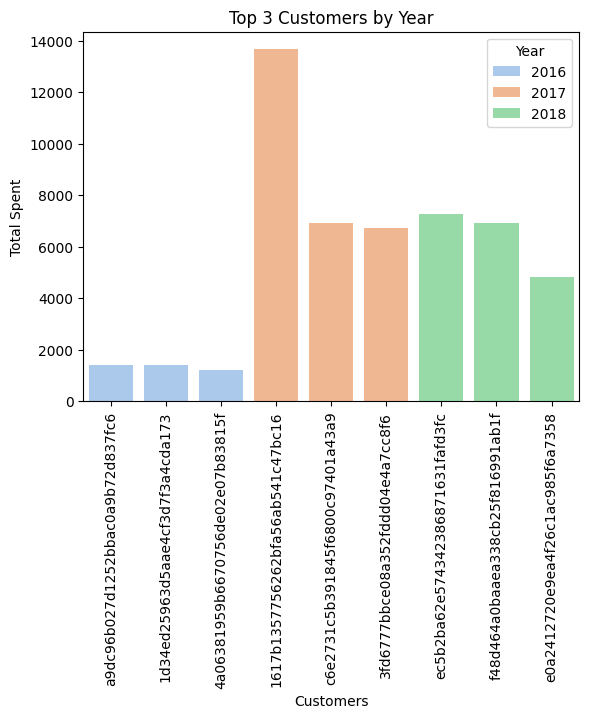

In [4]:
query="""WITH top_spenders AS (SELECT
    YEAR(order_purchase_timestamp) AS years, customer_id, SUM(payment_value) AS payment, DENSE_RANK()
        OVER
    (PARTITION BY YEAR(order_purchase_timestamp) ORDER BY SUM(payment_value) DESC) AS ranks
FROM
    payments
        JOIN
    orders ON payments.order_id=orders.order_id
GROUP BY YEAR(order_purchase_timestamp), customer_id)

SELECT years, customer_id, ROUND(payment,2), ranks FROM top_spenders WHERE ranks<=3"""
mycursor.execute(query)
data = mycursor.fetchall()
top_customers = pd.DataFrame(data, columns=['Year', 'Customer_ID', 'Total_Spent', 'Rank'])
print(top_customers)
sns.barplot(x='Customer_ID', y='Total_Spent', hue='Year', data=top_customers, palette='pastel')
plt.xlabel('Customers')
plt.ylabel('Total Spent')
plt.xticks(rotation=90)
plt.title('Top 3 Customers by Year')
plt.show()